In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from PIL import Image
from tqdm import tqdm
import os
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F 

USE_GPU = True
dtype = torch.float32 # We will be using float

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss.
print_every = 100
print('using device:', device)

using device: cuda


In [2]:
# Define the path to the dataset
dataset_path = "sign_datasets/sign-language-gesture-images-dataset/Gesture Image Data"

# Define the batch size
batch_size = 64

# Load the dataset without transformations
dataset = datasets.ImageFolder(root=dataset_path)

# Get the total number of samples
total_samples = len(dataset)
train_size = int(0.7 * total_samples)
val_size = int(0.2 * total_samples)
test_size = total_samples - train_size - val_size

# Print the sizes of each split
print(f"Total samples: {total_samples}")
print(f"Training set size: {train_size}")
print(f"Validation set size: {val_size}")
print(f"Test set size: {test_size}")

Total samples: 55500
Training set size: 38850
Validation set size: 11100
Test set size: 5550


In [3]:
# Already computed mean and std
computed_mean = [0.5273298025131226, 0.4507707953453064, 0.4120909869670868]
computed_std = [0.5632718205451965, 0.5085217952728271, 0.48751917481422424]

# Define the transformations
transform = transforms.Compose([
    #transforms.Resize((X, Y)),  # Resize images to X,Y if necessary
    transforms.ToTensor(),       # Convert images to PyTorch tensors
    transforms.Normalize(mean=computed_mean, std=computed_std)  # Normalize
])

dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Split the dataset into train, validation, and test sets
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders for each split
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Get class names
class_names = dataset.classes
print("Class names:", class_names)

# Example of iterating through the train DataLoader
for images, labels in train_loader:
    print("Train Batch - Images shape:", images.shape)
    print("Train Batch - Labels shape:", labels.shape)
    break

# Print dataset sizes for verification
print(f"Train set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

len_train_loader = len(train_loader)
len_val_loader = len(val_loader)
len_test_loader = len(test_loader)

# Print DataLoader sizes for verification
print(f"Train DataLoader size: {len(train_loader)}")
print(f"Validation DataLoader size: {len(val_loader)}")
print(f"Test DataLoader size: {len(test_loader)}")

Class names: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '_']
Train Batch - Images shape: torch.Size([64, 3, 50, 50])
Train Batch - Labels shape: torch.Size([64])
Train set size: 38850
Validation set size: 11100
Test set size: 5550
Train DataLoader size: 608
Validation DataLoader size: 174
Test DataLoader size: 87


In [4]:
def check_accuracy_part(loader, model, return_acc = False):
    # Determine the split type
    if len(loader) == len_train_loader:
        split = 'train'
    elif len(loader) == len_val_loader:
        split = 'val'
    elif len(loader) == len_test_loader:
        split = 'test'

    print(f'Checking accuracy on the {split} set')

    # init counters
    num_correct = 0
    num_samples = 0

    # set model to evaluation mode
    model.eval()  

     # Disable gradient computation as we dont train
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype) # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)  # use torch.long for labels

            # forward pass
            scores = model(x)
            _, preds = scores.max(1)  # get predicted class -> highest score

            # Count correct predictions and total samples
            correct_predictions = preds == y  # True if correct - False otherwise
            num_correct_batch = correct_predictions.sum().item() # count the correct predictions
            num_correct = num_correct + num_correct_batch

            num_samples_batch = preds.size(0)  # get the batch size
            num_samples = num_samples + num_samples_batch

    # compute and print accuracy
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f%%)' % (num_correct, num_samples, 100 * acc))
    
    if return_acc == True:
        return 100 * acc

In [6]:
def train_part(model, optimizer, epochs=1, return_acc = False, check_train_set = False, check_test_set = False):

    # List to store validation and train accuracies at each epoch where needed
    val_accs = []
    train_accs = []

    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(train_loader):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                check_accuracy_part(val_loader, model)
                print()

        # After each epoch, check accuracies
        val_acc = check_accuracy_part(val_loader, model, return_acc=True)
        val_accs.append(val_acc)
        print(f"Validation Accuracy after epoch {e+1}: {val_acc:.2f}%")
        
        # Return accuracies if requested
        if check_train_set:
            train_acc = check_accuracy_part(train_loader, model, return_acc=True)
            train_accs.append(train_acc)
            print(f"Training Accuracy after epoch {e+1}: {train_acc:.2f}%")

    # Return accuracies if requested
    if return_acc:
        if check_train_set:  # If requested, return both validation and training accuracies
            return val_accs, train_accs
        if check_test_set:  # If requested, return the validation accuracy and test accuracy
            test_acc = check_accuracy_part(test_loader, model, return_acc=True)  # Check test set accuracy
            return val_accs[-1], test_acc  # Return the most recent validation accuracy and the test accuracy
        return val_accs  # Return only validation accuracies if no other set (train or test) is specified

In [8]:
# 1. Convolutional layer (with bias) with 32 5x5 filters, with zero-padding of 2
# 2. ReLU
# 3. Convolutional layer (with bias) with 16 3x3 filters, with zero-padding of 1
# 4. ReLU
# 5. Fully-connected layer (with bias) to compute scores for the classes

channel_1 = 32
channel_2 = 16
learning_rate = 1e-3

in_channel = 3
num_classes = len(class_names)

# Define the model using nn.Sequential
model = nn.Sequential(
    nn.Conv2d(in_channel, channel_1, kernel_size=5, padding=2), # First conv layer with Relu
    nn.ReLU(),
    nn.Conv2d(channel_1, channel_2, kernel_size=3, padding=1), # Second conv layer with Relu
    nn.ReLU(),                                             
    nn.Flatten(), # Flatten the output
    nn.Linear(channel_2 * 50 * 50, num_classes) # Fully-connected layer, (channel_2 * 50 * 50) -> the number of features coming into the fully connected layer.
)

# You should optimize your model using stochastic gradient descent with Nesterov momentum 0.9.
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)


val_acc, test_acc = train_part(model, optimizer, return_acc=True, check_test_set = True)


# Print the validation and test accuracies
print()
print('########### Final Results ###########')
print("Validation Accuracy:", val_acc)
print("Test Accuracy:", test_acc)

Iteration 0, loss = 3.6187
Checking accuracy on the val set
Got 236 / 11100 correct (2.13%)

Iteration 100, loss = 0.2686
Checking accuracy on the val set
Got 10090 / 11100 correct (90.90%)

Iteration 200, loss = 0.0505
Checking accuracy on the val set
Got 10839 / 11100 correct (97.65%)

Iteration 300, loss = 0.0139
Checking accuracy on the val set
Got 11033 / 11100 correct (99.40%)

Iteration 400, loss = 0.0351
Checking accuracy on the val set
Got 11041 / 11100 correct (99.47%)

Iteration 500, loss = 0.0192
Checking accuracy on the val set
Got 11073 / 11100 correct (99.76%)

Iteration 600, loss = 0.0036
Checking accuracy on the val set
Got 11053 / 11100 correct (99.58%)

Checking accuracy on the val set
Got 10799 / 11100 correct (97.29%)
Validation Accuracy after epoch 1: 97.29%
Checking accuracy on the test set
Got 5419 / 5550 correct (97.64%)

########### Final Results ###########
Validation Accuracy: 97.2882882882883
Test Accuracy: 97.63963963963964


In [45]:
# Save the model's state_dict
torch.save(model, 'model.pth')

In [6]:
model = torch.load('model.pth')  # Load the entire model

# Move the model to device
model = model.to(device)

# Set the model to evaluation mode
model.eval()

/tmp/ipykernel_2080331/2237739796.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('model.pth')  # Load the entire model


Sequential(
  (0): Flatten()
  (1): Linear(in_features=7500, out_features=500, bias=True)
  (2): ReLU()
  (3): Linear(in_features=500, out_features=37, bias=True)
)

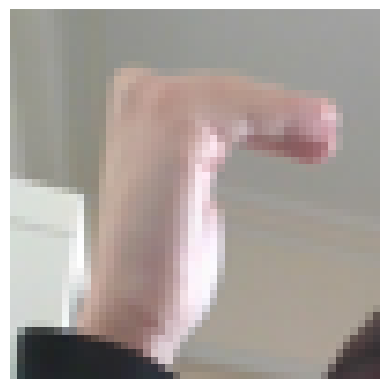

In [30]:
# Path to the image
#image_path = "sign_datasets/sign-language-gesture-images-dataset/Gesture Image Data/_/67.jpg"
#image_path = "sign_datasets/sign-language-gesture-images-dataset/Gesture Image PreProc1essed Data/S/67.jpg"
image_path = "sign_datasets/custom-dataset/_/0.jpg"

# Define the transformations (same as during training)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=computed_mean, std=computed_std)
])

# Load the image
image = Image.open(image_path)
image = image.convert("RGB")  # Ensure 3-channel RGB
image = image.resize((50, 50))  # Resize to match the input size if necessary

# Plot the resized image
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.show()

# Apply the transformations
input_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension

In [31]:
# Perform inference
with torch.no_grad():
    output = model(input_tensor)  # Raw scores (logits)
    predicted_idx = torch.argmax(output, dim=1).item()  # Get the index of the highest logit
    predicted_class = class_names[predicted_idx]  # Map to class name

print(f"Predicted class: {predicted_class}")

Predicted class: C
